# This notebook replaces the pruned index gradients with zero for updating weights.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import copy

from torchvision import datasets, models
from pathlib import Path
import torch.optim as optim
import torch.nn.utils.prune as prune
import pdb
import time
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')

torch.manual_seed(0)
np.random.seed(0)

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


Loading the datasets and dataloader:

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=4)
                                
classes = ('plane', 'car', 'bird', 'cat','deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(trainset)

50000

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 4)

Files already downloaded and verified


In [ ]:
len(testset)

10000

Loading the pretrained model:

In [ ]:
vgg19_CF10 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg19_bn", pretrained=True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg19_bn-57191229.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg19_bn-57191229.pt


  0%|          | 0.00/78.5M [00:00<?, ?B/s]

Validate function that produces the accuracy and runtime of the model:

In [ ]:
def validate_model(model, dataloader, device = "cuda", trials = 1):

    model.eval()

    dev = torch.device(device)
    model.to(dev)

    run_time = 0
    correct = 0
    total = 0 


    if (device == "cuda"):


      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)

        #print(f"i = {i}")
        start = time.time()

        inputs = inputs.to(dev)
        labels = labels.to(dev)
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        torch.cuda.synchronize()
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        predicted = predicted.to("cpu")
        labels = labels.to("cpu")

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total

      torch.cuda.empty_cache()

    elif (device == "cpu"):
      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)totalzeros = 0
        totalelements = 0
        start = time.time()
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total


    return run_time, accuracy

In [ ]:
acc_list = []
rntm_list = []
prune_list = []

Validate and record the stats for the original model:

In [ ]:
# Validate the original model and check the accuracy

gpu_og_runtime, gpu_og_accuracy = validate_model(vgg19_CF10, testloader, device = "cuda")

[250] accuracy : 80.9000%
[500] accuracy : 81.2500%
[750] accuracy : 80.8000%
[1000] accuracy : 81.1250%
[1250] accuracy : 81.2800%
[1500] accuracy : 81.3667%
[1750] accuracy : 81.2286%
[2000] accuracy : 81.4250%
[2250] accuracy : 81.3667%
[2500] accuracy : 81.3100%


In [ ]:
acc_list.append(gpu_og_accuracy)
rntm_list.append(gpu_og_runtime)
prune_list.append(0)

### Pruning 20% weights structurally along each input channel.

Function to check sparsity of model:

In [ ]:
def check_sparse(model):
    totalzeros = 0
    totalelements = 0
    for child in model.children():
        #print(child)
        for layer in child.modules(): 
            if(isinstance(layer,torch.nn.modules.Conv2d) or isinstance(layer,torch.nn.modules.Linear)):
                nzeros = torch.sum(layer.weight == 0)
                nelement = layer.weight.nelement()
                totalzeros += nzeros
                totalelements += nelement
                print("Sparsity: {:.2f}%".format(100. * float(nzeros) / float(nelement)))
    print("Global Sparsity: {:.2f}%".format(100. * float(totalzeros) / float(totalelements)))
    return format(100. * float(totalzeros) / float(totalelements))
            

Function to prune and retrain the model:

In [ ]:
def prune_and_retrain(model, prune_amount, train_epochs):

    # global convs_to_prune
    convs_to_prune = (
        (vgg19_CF10.features[0], 'weight'), # conv1 of VGG16
        (model.features[3], 'weight'),
        (model.features[7], 'weight'),
        (model.features[10], 'weight'),
        (model.features[14], 'weight'),
        (model.features[17], 'weight'),
        (model.features[20], 'weight'),
        (model.features[23], 'weight'),
        (model.features[27], 'weight'),
        (model.features[30], 'weight'),
        (model.features[33], 'weight'),
        (model.features[36], 'weight'),
        (model.features[40], 'weight'),
        (model.features[43], 'weight'),
        (model.features[46], 'weight'),
        (model.features[49], 'weight'),
    )
    # global linears_to_prune
    linears_to_prune = (
        (model.classifier[0], 'weight'),
        (model.classifier[3], 'weight')
        #  ,(model.classifier[6], 'weight')
    ) 

    for param, name in convs_to_prune:
        prune.ln_structured(param, name=name, amount=prune_amount/100, n=2, dim=0)
    for param, name in linears_to_prune:
        prune.ln_structured(param, name=name, amount=prune_amount/100, n=2, dim=0)
        

    print("===============================\nSPARSITY\n===============================")
    check_sparse(model)

    # global conv_mask_list
    conv_mask_list = []
    for param, name in convs_to_prune:
        conv_mask_list.append(param.weight_mask)

    # global lin_mask_list
    lin_mask_list = []
    for param, name in linears_to_prune:
        lin_mask_list.append(param.weight_mask)

    
    for param, name in convs_to_prune:
        prune.remove(param, name)
    for param, name in linears_to_prune:
        prune.remove(param, name)

    # check accuracy of the pruned model.
    print("\n\n===============================\nPRUNED MODEL ACCURACY\n===============================\n\n")
    rntm, acc = validate_model(model, testloader, device = "cuda")                  
    
    acc_list.append(acc)
    rntm_list.append(rntm)
    prune_list.append(prune_amount)    

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Batch size changed from 4 to 64 as in the paper.
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=False, num_workers=2)
    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    # declare optimiser and loss here
    # also inlcude parameters such as weight decay
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0001)

    print("\n\n===============================\nTraining model\n===============================\n")
    
    for epoch in range(train_epochs):
        running_loss = 0
        model.train()
        dev = torch.device("cuda")
        model.to(dev)
        print(f"EPOCH = {epoch}")
        
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            inputs = inputs.to(dev)
            labels = labels.to(dev)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            # at this point we have back propogated the loss. 
            # but we still hvae not changed the weights.
            # before we change the weights, we make the gradients corresponding to the pruned indices 0.

            # conv_mask_list = conv_mask_list.to(dev)
            # lin_mask_list = lin_mask_list.to(dev)

            conv_mask_idx = 0
            for param, name in convs_to_prune:
                # here param is the layer - linear / conv2d, ...
                index_tensor = conv_mask_list[conv_mask_idx]
                index_tensor = index_tensor.to(dev)
                param.weight.grad = param.weight.grad * index_tensor
                conv_mask_idx += 1

            lin_mask_idx = 0
            for param, name in linears_to_prune:
                index_tensor = lin_mask_list[lin_mask_idx]
                index_tensor = index_tensor.to(dev)
                param.weight.grad = param.weight.grad * index_tensor
                lin_mask_idx += 1

            optimizer.step()

            running_loss += loss.item()

            if i % (100) == (100) - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {(running_loss):.8f}')
                running_loss = 0.0

    print("\n\n===============================\nRETRAINED MODEL ACCURACY\n===============================\n\n")
    rntm, acc = validate_model(model, testloader, device = "cuda")     


    acc_list.append(acc)
    rntm_list.append(rntm)
    prune_list.append(prune_amount) 

    print("\n\n===============================\nRETRAINED MODEL SPARSITY\n===============================\n")
    check_sparse(model) 


    return model

Pruning and retraining the model till accuracy matches the original model:

In [ ]:
epchs = 4
vgg19_CF10_v1 = prune_and_retrain(vgg19_CF10, 20, epchs)


SPARSITY
Sparsity: 20.31%
Sparsity: 20.31%
Sparsity: 20.31%
Sparsity: 20.31%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 19.92%
Sparsity: 0.00%
Global Sparsity: 19.92%


PRUNED MODEL ACCURACY


[250] accuracy : 26.5000%
[500] accuracy : 26.3000%
[750] accuracy : 26.0667%
[1000] accuracy : 25.8500%
[1250] accuracy : 26.2400%
[1500] accuracy : 25.8667%
[1750] accuracy : 25.7857%
[2000] accuracy : 25.6875%
[2250] accuracy : 25.8222%
[2500] accuracy : 25.7300%
Files already downloaded and verified


Training model

EPOCH = 0
[1,   100] loss: 109.48466391
[1,   200] loss: 71.73251173
[1,   300] loss: 56.33361259
[1,   400] loss: 50.78873134
[1,   500] loss: 47.53489263
[1,   600] loss: 45.84224784
[1,   700] loss: 41.91595301
EPOCH = 1
[2,   100] loss: 36.90682465
[2,   200] loss: 32.28693350
[2,   300] los

In [ ]:
vgg19_CF10_v2 = prune_and_retrain(vgg19_CF10_v1, 40, epchs)

SPARSITY
Sparsity: 40.62%
Sparsity: 40.62%
Sparsity: 39.84%
Sparsity: 39.84%
Sparsity: 39.84%
Sparsity: 39.84%
Sparsity: 39.84%
Sparsity: 39.84%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 40.04%
Sparsity: 0.00%
Global Sparsity: 40.01%


PRUNED MODEL ACCURACY


[250] accuracy : 19.2000%
[500] accuracy : 18.2000%
[750] accuracy : 17.8000%
[1000] accuracy : 17.6500%
[1250] accuracy : 17.7600%
[1500] accuracy : 17.6833%
[1750] accuracy : 17.9000%
[2000] accuracy : 18.1250%
[2250] accuracy : 18.0333%
[2500] accuracy : 17.9800%
Files already downloaded and verified


Training model

EPOCH = 0
[1,   100] loss: 38.21450263
[1,   200] loss: 29.85738152
[1,   300] loss: 31.92807664
[1,   400] loss: 28.56716280
[1,   500] loss: 27.63373475
[1,   600] loss: 27.17742125
[1,   700] loss: 25.30904979
EPOCH = 1
[2,   100] loss: 24.96402436
[2,   200] loss: 20.42352258
[2,   300] loss

In [ ]:
vgg19_CF10_v3 = prune_and_retrain(vgg19_CF10_v2, 60, epchs)

SPARSITY
Sparsity: 59.38%
Sparsity: 59.38%
Sparsity: 60.16%
Sparsity: 60.16%
Sparsity: 60.16%
Sparsity: 60.16%
Sparsity: 60.16%
Sparsity: 60.16%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 59.96%
Sparsity: 0.00%
Global Sparsity: 59.97%


PRUNED MODEL ACCURACY


[250] accuracy : 10.3000%
[500] accuracy : 9.9500%
[750] accuracy : 9.9000%
[1000] accuracy : 9.7750%
[1250] accuracy : 10.0000%
[1500] accuracy : 10.0667%
[1750] accuracy : 10.0286%
[2000] accuracy : 10.0750%
[2250] accuracy : 10.2000%
[2500] accuracy : 10.0600%
Files already downloaded and verified


Training model

EPOCH = 0
[1,   100] loss: 62.29927590
[1,   200] loss: 49.49758902
[1,   300] loss: 45.86468242
[1,   400] loss: 43.74458003
[1,   500] loss: 40.70235364
[1,   600] loss: 41.53741701
[1,   700] loss: 36.91856905
EPOCH = 1
[2,   100] loss: 30.18001310
[2,   200] loss: 30.85960203
[2,   300] loss: 3

In [ ]:
vgg19_CF10_v4 = prune_and_retrain(vgg19_CF10_v3, 80, epchs)

SPARSITY
Sparsity: 79.69%
Sparsity: 79.69%
Sparsity: 79.69%
Sparsity: 79.69%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 80.08%
Sparsity: 0.00%
Global Sparsity: 80.05%


PRUNED MODEL ACCURACY


[250] accuracy : 10.3000%
[500] accuracy : 9.9500%
[750] accuracy : 9.8333%
[1000] accuracy : 9.7250%
[1250] accuracy : 9.9400%
[1500] accuracy : 10.0167%
[1750] accuracy : 9.9714%
[2000] accuracy : 10.0125%
[2250] accuracy : 10.1444%
[2500] accuracy : 10.0000%
Files already downloaded and verified


Training model

EPOCH = 0
[1,   100] loss: 133.30049163
[1,   200] loss: 102.21881902
[1,   300] loss: 93.66000867
[1,   400] loss: 90.58749819
[1,   500] loss: 82.77137733
[1,   600] loss: 83.94944119
[1,   700] loss: 78.36169326
EPOCH = 1
[2,   100] loss: 74.62301147
[2,   200] loss: 70.85937938
[2,   300] loss: 6

In [ ]:
acc_list

[tensor(81.3100, dtype=torch.float64),
 tensor(25.7300, dtype=torch.float64),
 tensor(85.2800, dtype=torch.float64),
 tensor(17.9800, dtype=torch.float64),
 tensor(86.0500, dtype=torch.float64),
 tensor(10.0600, dtype=torch.float64),
 tensor(83.6000, dtype=torch.float64),
 tensor(10., dtype=torch.float64),
 tensor(80.1300, dtype=torch.float64)]

In [ ]:
rntm_list

[19.244603633880615,
 12.676271438598633,
 12.521683931350708,
 12.874413967132568,
 12.978211402893066,
 13.029207706451416,
 12.934014320373535,
 13.122860193252563,
 12.741387605667114]

Plotting the results:

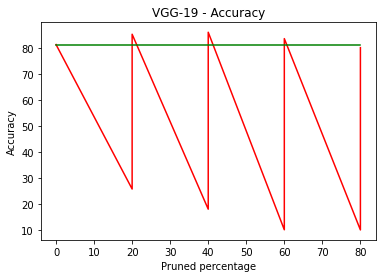

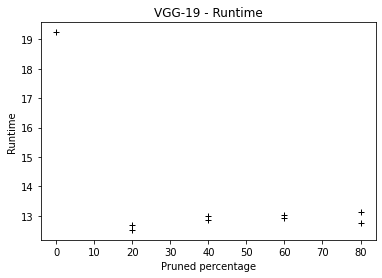

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


new_accu_list = []
for ele in acc_list:
    new_accu_list.append(ele.item())

baseline = np.ones(len(new_accu_list))*81.31
# plotting
plt.title("VGG-19 - Accuracy")
plt.xlabel("Pruned percentage")
plt.ylabel("Accuracy")
plt.plot(prune_list, new_accu_list, color ="red")
plt.plot(prune_list, baseline, color ="green")
plt.show()


plt.title("VGG-19 - Runtime")
plt.xlabel("Pruned percentage")
plt.ylabel("Runtime")
plt.plot(prune_list, rntm_list, 'r+', color ="black")
plt.show()